# Impacts of Flood

## Risk assessment methodology

Deterministic flood risk is calculated as a combination of flood extent maps of different return periods and flood damage.

- River flood extent and water depth: available from the [Copernicus Land Monitoring Service](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different return periods. Flood extent map of 100m resolution  
- Land-use information: The land cover map is available from the [Copernicus Land Monitoring Service](https://land.copernicus.eu/pan-european/corine-land-cover)   
- Flood damage: assessed as a combination between flood extent/water depths and damage curve (available [here](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688). For each pixel, the water depths are used as input in the damage curve to assess the damage, together with different land use and country.   

These are examples of possible datasets, the idea is that a user could apply the methodology even with their own data  

## Preparation work

### Load libraries

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - A data retrieval and storage utility that simplifies downloading and managing datasets.
- [numpy](https://numpy.org/): A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/): A data manipulation and analysis library, essential for working with structured data in tabular form.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - A library for reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data in GeoTIFF format.
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - A library designed for calculating flood damages based on geospatial data, particularly suited for analyzing flood impact.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/) A library for adding basemaps to plots, enhancing geospatial visualizations.


These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.


In [1]:
# Package for downloading data and managing files
import os
import pooch

# Packages for working with numerical data and tables
import numpy as np
import pandas as pd

# Packages for handling geospatial maps and data
import rioxarray as rxr
import rasterio
from rasterio.enums import Resampling

# Package for calculating flood damages
from damagescanner.core import RasterScanner

# Ppackages used for plotting maps
import matplotlib.pyplot as plt
import contextily as ctx


### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called notebook in the same directory where this notebook is saved.

In [2]:
# Define the folder for the flood workflow
workflow_folder = 'flood_workflow'

# Check if the workflow folder exists, if not, create it along with subfolders for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(workflow_folder, 'data'))
    os.makedirs(os.path.join(workflow_folder, 'results'))

### Download data

The data we are using is available as compressed ZIP files in the JRC data portal. 
Since there is no API to download this data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to donwload and unzip the data.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

#### Flood data

First we download the flood data for 10, 20, 50, 100, 200 and 500 years.  

In the list of [pairs](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) **return_periods**, first value is the return period, and second value is the [hash of the dataset](https://www.fatiando.org/pooch/latest/hashes.html).  

Next cell will:
- create the create the **data** folder inside the notebook folder
- [loop](https://wiki.python.org/moin/ForLoop) through all return periods and download and unzip each file in the data folder (if the data doesn't already exist).

Data for each return period can also be manually downloaded from [this link](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) in the JRC data portal.

In [3]:
# Define directories for data and results within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, 'data')
results_dir = os.path.join(workflow_folder, 'results')

In [4]:
# Define a list of return periods with associated hash values
return_periods = [('010', '6dfba3cba22bf99fefb45e66963b8dbf7054e81b8a6b46258eff6ffda686d2a4'), 
                  ('020', 'a497725f7edf00ed01f3084e3d755b77294c53939b5f7ad5174f59c0331a5d34'), 
                  ('050', '47a804f617b0bbc9646ae3274e4959ba21edf4ef2bac778051f86ce7fcf4cde5'), 
                  ('100', 'cecda59c96d6dcd340a1ff2e82efc1caabd5c98d650b70fca5e802fd01872cae'),
                  ('200', '9988c310a306c8244fda542b6e5ea2956a5b98ffc06ed3104cef869443646533'),
                  ('500', 'a64803d8e31ca35bff0e386388d44b06674c78e3e8777e1d44a05098e0730268')]

# Loop through each return period and download the corresponding flood map
for item in return_periods:
    return_period, khash = item
    url = f'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/FLOODS/EuropeanMaps/floodMap_RP{return_period}.zip'
    pooch.retrieve(
        url=url,
        known_hash=khash,
        processor=pooch.Unzip(extract_dir=''),
        path=data_dir,
    )

Note that now we have a directory **flood_workflow/data** where all the zip files and unzipped flood files are. Take a look and check if the files are there.  

#### Land-use information
Next we need the information on land use.  
We will download it from the JRC data portal.
:::{note}
Once the data is downloaded and unzipped, Pooch will list the content of the directory with the data.
:::

In [67]:
# Define the URL for the LUISA basemap and download it using Pooch
url = 'http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/2018/VER2021-03-24/LUISA_basemap_020321_50m.tif'
pooch.retrieve(
    url=url,
    known_hash=None,  # Hash value is not provided
    path=data_dir,    # Save the file to the specified data directory
    fname='LUISA_basemap_020321_50m.tif'  # Save the file with a specific name
)

'C:\\Users\\buskop\\OneDrive - Stichting Deltares\\Documents\\GitHub\\FLOODS\\flood_workflow\\data\\LUISA_basemap_020321_50m.tif'

#### Damage curves

We will use damage curves files from the JRC.


Text(0, 0.5, 'Damage ratio [%]')

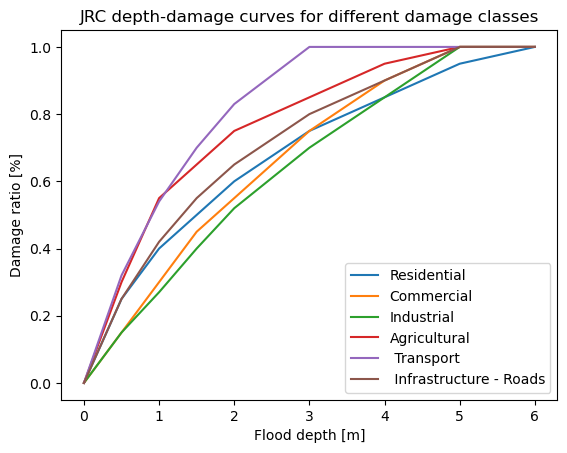

In [7]:
# Import damage curves of the JRC from a CSV file into a pandas DataFrame
JRC_curves = pd.read_csv('JRC_damage_curves.csv', index_col=0)

# Plot the JRC depth-damage curves
JRC_curves.plot()

# Set the title and labels for the plot
plt.title('JRC depth-damage curves for different damage classes')
plt.xlabel('Flood depth [m]')
plt.ylabel('Damage ratio [%]')

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Flood data
We have downloaded river flood hazard map of Europe and the Mediterranean Basin Region.    
The maps depict river flood depths (in meters) for six different flood frequencies (from 1-in-10-years to 1-in-500-years). The extent comprises most of the geographical Europe and all the river basins entering the Mediterranean and Black Seas in the Caucasus, Middle East and Northern Africa countries.

The maps can be used to assess multipe types of risk to river flooding in a region. Potential uses are the exposure of population, economic assets to river floods, flooded roads, assessing acces to healthcare facilities, etc. In this risk recipe we will look into economic damages.

All the downloaded files are stored in our **data_dir** folder, with filenames starting with: **floodmap_EFAS_RP** folowed by the number of years for the return period.  

:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics 👇
:class: dropdown
👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the spatial information  
👋 Look at _STATISTICS_ attributes to find minimum, maximum and other statistics

:::

In [70]:
# Define the filename for the flood map based on the specified data directory
filename_flood = f'{data_dir}/floodmap_EFAS_RP500_C.tif'

# Open the flood map raster using rioxarray
flood = rxr.open_rasterio(filename_flood)

# Display the opened flood map
flood

<xarray.DataArray (band: 1, y: 45242, x: 63976)>
[2894402192 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9.19e+05 9.19e+05 9.192e+05 ... 7.316e+06 7.316e+06
  * y            (y) float64 5.441e+06 5.44e+06 5.44e+06 ... 9.166e+05 9.164e+05
    spatial_ref  int32 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  8.857045422371877
    STATISTICS_MAXIMUM:      276.49700927734
    STATISTICS_MEAN:         2.3875402056979
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.976078866961
    _FillValue:              -3.402823e+38
    scale_factor:            1.0
    add_offset:              0.0

### Land use data
All the Land use data is extracted in the LUISA_LU directory inside our data_dir folder. Take a look a the files First we have the land use projections for 2010, 2020, 2030, 2040 and 2050. Using maps from the past, past events can be reconstructed. By using future maps, added or decreased risk due to changes in landuse can be found. We also have files labeled with **legend** that provide metadata and mapping between different land use classes.

Let's explore one of the land use projection files, for example 2030 projection (2030_LUISA_LU).  
We will use rioxarray to open the file and list its content.

In [71]:
# Define the filename for the land use map based on the specified data directory
filename_land_use = f'{data_dir}/LUISA_basemap_020321_50m.tif'

# Open the land use map raster using rioxarray
land_use = rxr.open_rasterio(filename_land_use)

# Display the opened land use map
land_use

<xarray.DataArray (band: 1, y: 92000, x: 130000)>
[11960000000 values with dtype=int32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9e+05 9.001e+05 9.001e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.001e+05 9e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

## Process the data

If we have a closer look at the x and y dimensions of the flood and landuse datasets, we can see that the data have different resolutions. Flood extent maps are at 100 m resolution, while land use data is at 50 m resolution. We can use xarray to get them to the same resolution.  

But first we need to clip them to the same area, so we don't interpolate the whole global field (this takes a lot of time to do). For this we use the rioxarray library again.. you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' and copy the values in the brackets below

In this example we are clipping the bounding box around Barcelona.

In [49]:
bbox = [1.983871,41.252461,2.270614,41.449569] # Barcelona, Spain

Text(0.5, 1.0, 'LUISA Land Cover for the defined area')

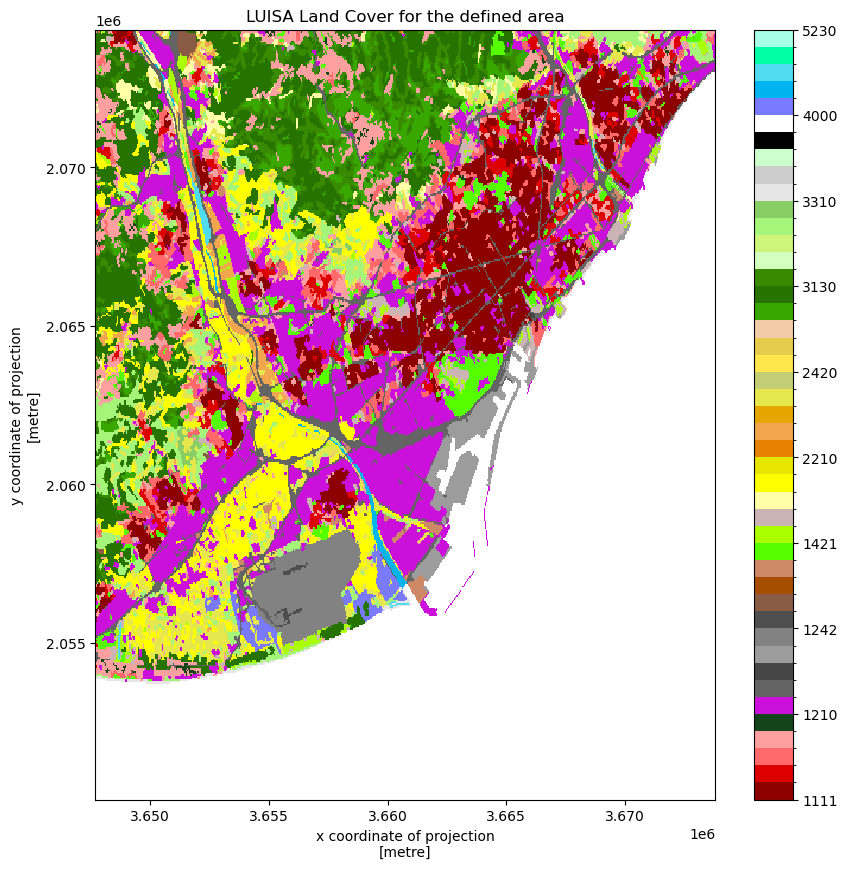

In [50]:
# Set the coordinate reference system (CRS) for the land use map to EPSG:3035
land_use.rio.write_crs(3035, inplace=True)

# Clip the land use map to the specified bounding box and CRS
land_use_small_area = land_use.rio.clip_box(*bbox, crs="EPSG:4326")

# Define values and colors for different land use classes
LUISA_values = [1111, 1121, 1122, 1123, 1130,
                1210, 1221, 1222, 1230, 1241,
                1242, 1310, 1320, 1330, 1410,
                1421, 1422, 2110, 2120, 2130,
                2210, 2220, 2230, 2310, 2410,
                2420, 2430, 2440, 3110, 3120,
                3130, 3210, 3220, 3230, 3240,
                3310, 3320, 3330, 3340, 3350,
                4000, 5110, 5120, 5210, 5220,
                5230]

LUISA_colors = ["#8c0000", "#dc0000", "#ff6969", "#ffa0a0", "#14451a",
                "#cc10dc", "#646464", "#464646", "#9c9c9c", "#828282",
                "#4e4e4e", "#895a44", "#a64d00", "#cd8966", "#55ff00",
                "#aaff00", "#ccb4b4", "#ffffa8", "#ffff00", "#e6e600",
                "#e68000", "#f2a64d", "#e6a600", "#e6e64d", "#c3cd73",
                "#ffe64d", "#e6cc4d", "#f2cca6", "#38a800", "#267300",
                "#388a00", "#d3ffbe", "#cdf57a", "#a5f57a", "#89cd66",
                "#e6e6e6", "#cccccc", "#ccffcc", "#000000", "#ffffff",
                "#7a7aff", "#00b4f0", "#50dcf0", "#00ffa6", "#a6ffe6",
                "#e6f2ff"]

# Plot the land use map using custom levels and colors
land_use_small_area.plot(levels=LUISA_values, colors=LUISA_colors, figsize=(10, 10))

# Set the title for the plot
plt.title('LUISA Land Cover for the defined area')


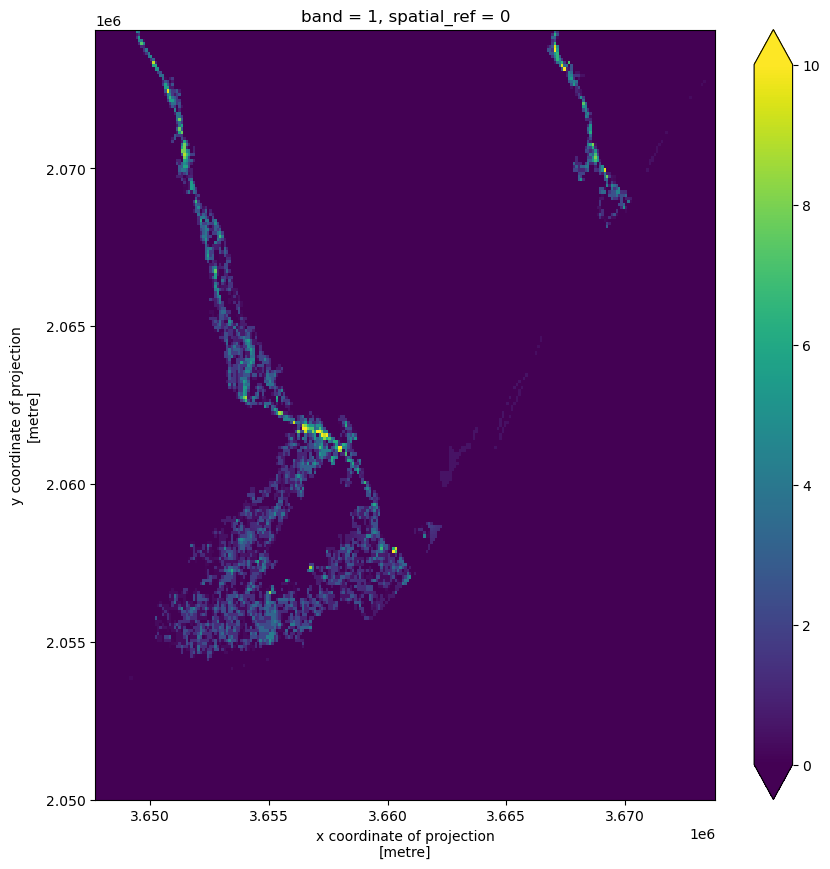

In [76]:
# Clip the flood map to the specified bounding box and CRS
flood_small_area = flood.rio.clip_box(
    *bbox,
    crs="EPSG:4326",
)

# Plot the clipped flood map with specified color map limits
flood_small_area.plot(figsize=(10, 10), vmin=0, vmax=10)

# Set the title for the plot
plt.title('Flood map for the defined area')

#### Interpolate the land use data array

Next we need to interpolate the flood data into the land use map grid in order to be able to calculate the damage map.  
We can use the xarray [**interp_like()**](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp_like.html) function, that will interpolate the land use data into flood grid.  

In case our land use map was courses we would not like to actually interpolate the land use values between gridcells because then 'new' land use values will be created that do not have a meaning. To prevent that we are using method **'nearest'**, to assign the values to the nearest grid points.

In [78]:
# Reproject the clipped flood map to match the resolution and extent of the land use map
flood_small_area_matched = flood_small_area.rio.reproject_match(land_use_small_area, resampling=Resampling.bilinear)


In [79]:
# check the new resolution of the floodmap
flood_small_area_matched.rio.resolution()

(50.0, -50.0)

For now we save them as tif so DamageScanner package can use them as input.

In [57]:
# Create a new GeoTIFF file for the matched flood map
with rasterio.open(
    f'{data_dir}/flood_small_area_matched.tif',
    'w',
    driver='GTiff',
    height=flood_small_area_matched.shape[1],
    width=flood_small_area_matched.shape[2],
    count=1,
    dtype=str(flood_small_area_matched.dtype),
    crs=flood_small_area_matched.rio.crs,
    transform=flood_small_area_matched.rio.transform()
) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(flood_small_area_matched.values)


In [58]:
# Create a new GeoTIFF file for the clipped land use map
with rasterio.open(
    f'{data_dir}/land_use_small_area.tif',
    'w',
    driver='GTiff',
    height=land_use_small_area.shape[1],
    width=land_use_small_area.shape[2],
    count=1,
    dtype=str(land_use_small_area.dtype),
    crs=land_use_small_area.rio.crs,
    transform=land_use_small_area.rio.transform()
) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(land_use_small_area.values)


### Additional info for the LUISA land use maps

In order to assess the damage done by the flood we also need to assign a monetary value to the land use categories. We define this as the potential loss in €/m². Go into the provided **LUISA_damage_info_curves.xlsx** and tweak the information to your own region.

In [59]:
# Read damage curve information from an Excel file into a pandas DataFrame
LUISA_info_damage_curve = pd.read_excel('LUISA_damage_info_curves.xlsx', index_col=0)

# Extract the 'total €/m²' column to get the maximum damage for reconstruction
maxdam = pd.DataFrame(LUISA_info_damage_curve['total €/m²'])

# Save the maximum damage values to a CSV file
maxdam.to_csv(f'{data_dir}/maxdam_luisa.csv')

# Display the first 10 rows of the resulting DataFrame
maxdam.head(10)


,total €/m²
Land use code,
1111,600.269784
1121,414.499401
1122,245.022999
1123,69.919184
1130,0.000000
1210,405.238393
1221,40.417363
1222,565.843080
1230,242.504177


Text(0.5, 0, 'Inundation depth (m)')

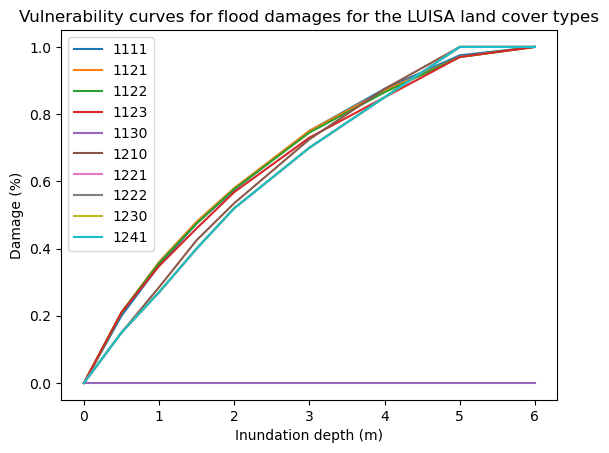

In [60]:
# Create a new DataFrame for damage_curves_luisa by copying JRC_curves
damage_curves_luisa = JRC_curves.copy()

# Drop all columns in the new DataFrame
damage_curves_luisa.drop(damage_curves_luisa.columns, axis=1, inplace=True)

# Define building types for consideration
building_types = ['residential', 'commercial', 'industrial']

# For each land use class in maxdamage, create a new damage curve
for landuse in maxdam.index:
    # Find the ratio of building types in the class
    ratio = LUISA_info_damage_curve.loc[landuse, building_types].values

    # Create a new curve based on the ratios and JRC_curves
    damage_curves_luisa[landuse] = ratio[0] * JRC_curves.iloc[:, 0] + \
                                   ratio[1] * JRC_curves.iloc[:, 1] + \
                                   ratio[2] * JRC_curves.iloc[:, 2]

# Save the resulting damage curves to a CSV file
damage_curves_luisa.to_csv(f'{data_dir}/curves.csv')    

# Plot the vulnerability curves for the first 10 land cover types
damage_curves_luisa.iloc[:, 0:10].plot()
plt.title('Vulnerability curves for flood damages for the LUISA land cover types')
plt.ylabel('Damage (%)')
plt.xlabel('Inundation depth (m)')


## Calculate the damage using DamageScanner library

Now that we have all pieces of the puzzle in place, we can start doing the risk calculation. For this we are using the [DamageScanner](https://damagescanner.readthedocs.io/en/latest/index.html) python library which allows for an easy damage calculation. 

The DamageScanner takes the following data:
- The clipped and resampled flood map 
- The clipped landuse map
- The created vulnerability curves 
- A table of maximum damages per landuse category 

In [62]:
# Define file paths for the flood map, land use map, vulnerability curves, and maximum damages
inun_map = os.path.join(data_dir, 'flood_small_area_matched.tif')
landuse_map = os.path.join(data_dir, 'land_use_small_area.tif')
curve_path = os.path.join(data_dir, 'curves.csv')
maxdam_path = os.path.join(data_dir, 'maxdam_luisa.csv')


In [63]:
# Do the damage calculation and save the results as 'flood_scenario'
loss_df = RasterScanner(landuse_map,
                        inun_map,
                        curve_path,
                        maxdam_path, 
                        save = True, 
                        nan_value = None, 
                        scenario_name= f'{results_dir}/flood_scenario',
                        dtype = np.int64)

In [93]:
# Obtain the LUISA legend and add it to the table of damages
LUISA_legend = LUISA_info_damage_curve['Description']

# Combine loss_df with LUISA_legend
catagory_damage = pd.concat([LUISA_legend, (loss_df[0])], axis=1)

# Convert the damages to million euros
catagory_damage['damage mln.'] = catagory_damage['damages'] / 10**6

# Drop the 'damages' column
catagory_damage.drop('damages', axis=1, inplace=True)

# Sort the values by damage in descending order
catagory_damage.sort_values(by='damage mln.', ascending=False, inplace=True)

# Display the resulting DataFrame
catagory_damage


,Description,damage mln.
1241,Airport areas,1033.460502
1210,Industrial or commercial units,605.159893
2120,Permanently irrigated land,221.334689
2310,Pastures,145.012478
1330,Construction sites,69.118555
1221,Road and rail networks and associated land,57.607729
2220,Fruit trees and berry plantations,56.480082
4000,Wetlands,50.766320
3230,Sclerophyllous vegetation,47.507622
1421,Sport and leisure green,28.181313


## Plot the results

Now we plot the damages to get a spatial view of what places are financially most affected.

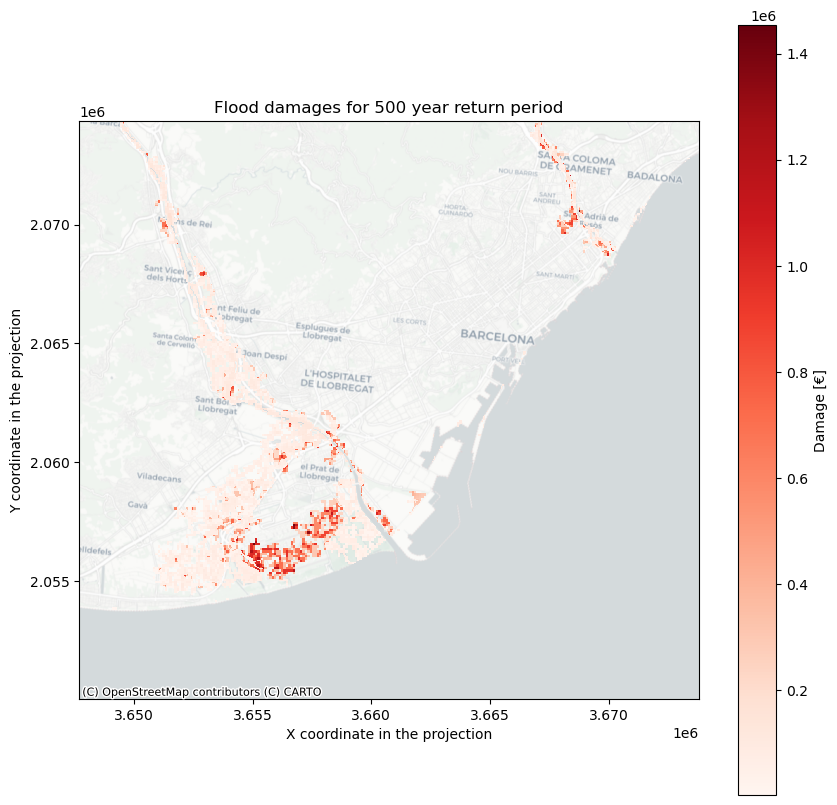

In [94]:
# Open a raster file representing flood damages for a specific scenario
damagemap = rxr.open_rasterio(f'{results_dir}/scenario200_damagemap.tif')

# Select values in the damagemap that are greater than 0
damagemap = damagemap.where(damagemap > 0)

# Create a plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the damagemap with a color map representing damages and a color bar
damagemap.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Damage [€]"})

# Set plot title and labels for X and Y coordinates
plt.title('Flood damages for 500 year return period')
plt.xlabel('X coordinate in the projection')
plt.ylabel('Y coordinate in the projection')

# Add a basemap background to the plot using Contextily
ctx.add_basemap(ax=ax, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

To get a better indication of why certain areas are damaged more than others, we also plot the floodmap and land use maps in one figure.

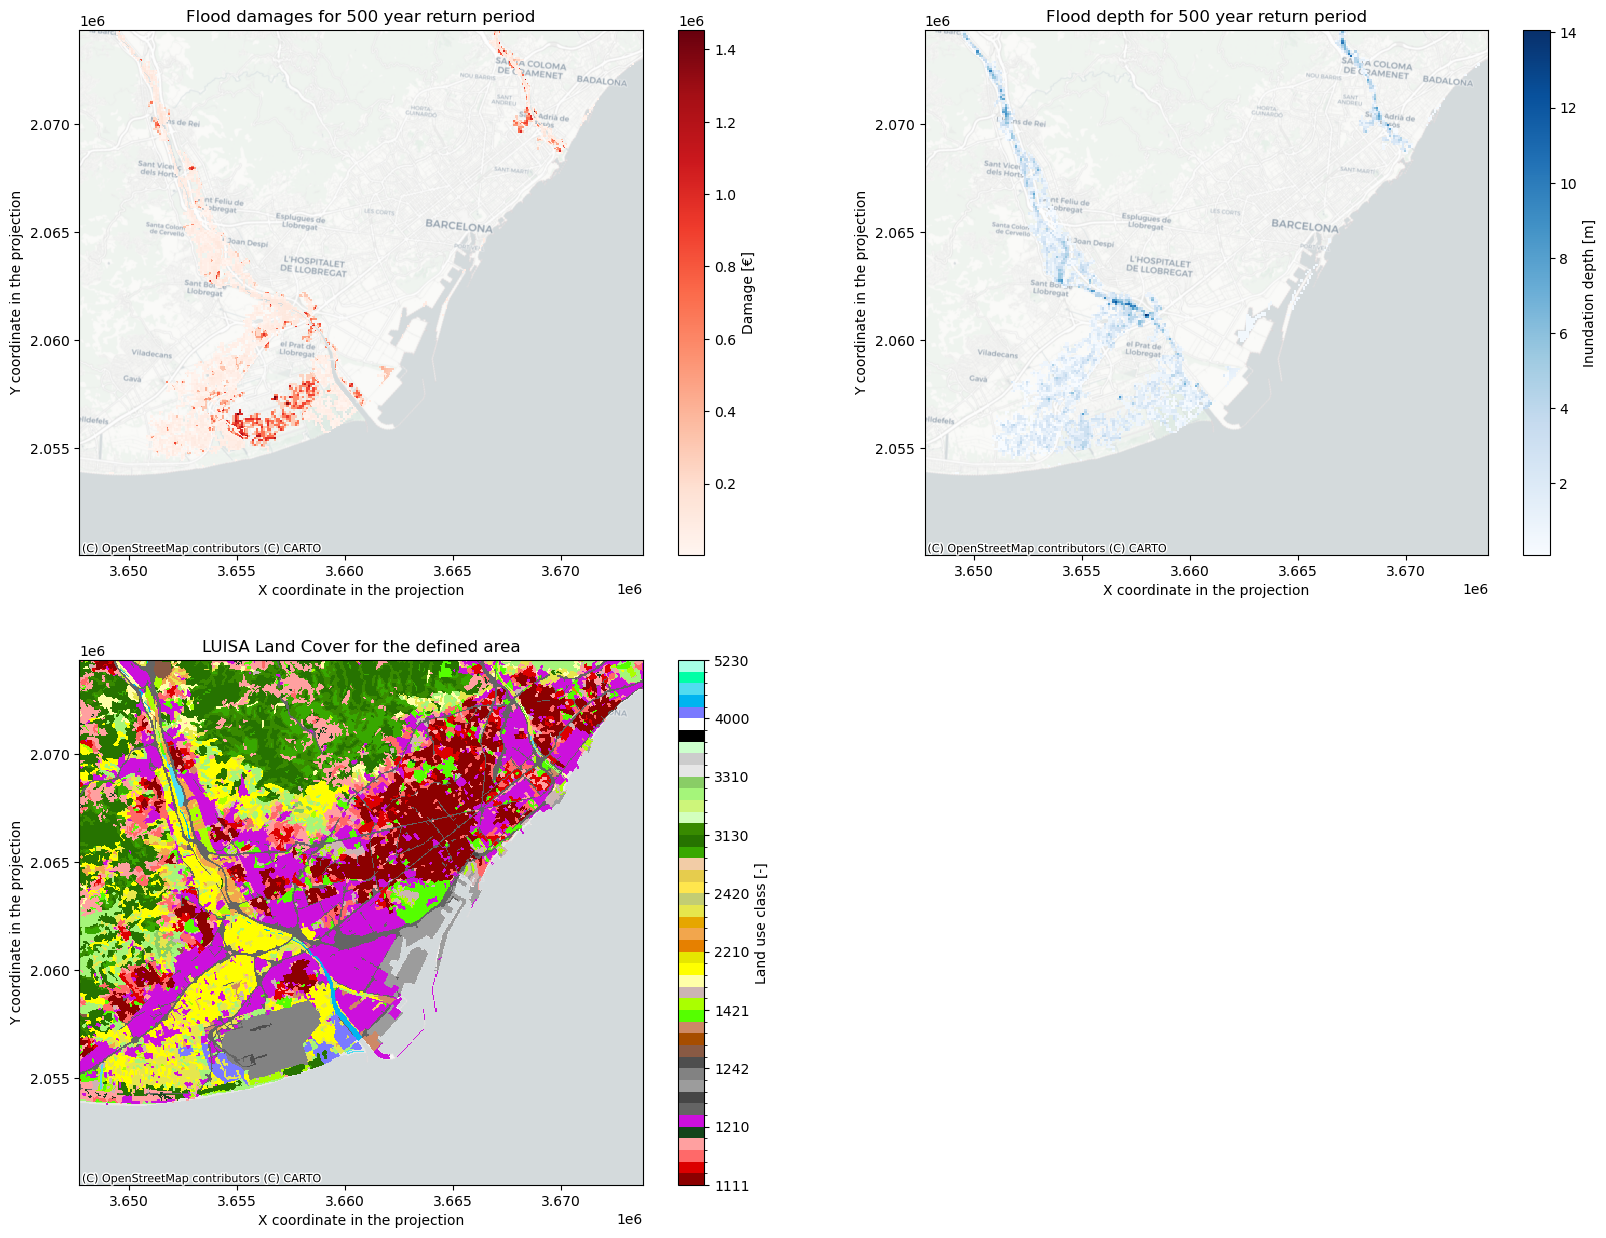

In [66]:
# Create a 2x2 grid of plots with a size of 20x15 inches
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20, 15))

# Plot flood damages on the first plot
damagemap.plot(ax=ax1, cmap='Reds', cbar_kwargs={'label': "Damage [€]"})
ax1.set_title('Flood damages for 500 year return period')
ax1.set_xlabel('X coordinate in the projection')
ax1.set_ylabel('Y coordinate in the projection')

# Plot inundation depth on the second plot
flood_small_area_matched.where(flood_small_area_matched > 0).plot(ax=ax2, cmap='Blues', cbar_kwargs={'label': "Inundation depth [m]"})
ax2.set_title('Flood depth for 500 year return period')
ax2.set_xlabel('X coordinate in the projection')
ax2.set_ylabel('Y coordinate in the projection')

# Plot land use on the third plot with custom colors
land_use_small_area.plot(ax=ax3, levels=LUISA_values, colors=LUISA_colors, cbar_kwargs={'label': "Land use class [-]"})
ax3.set_title('LUISA Land Cover for the defined area')
ax3.set_xlabel('X coordinate in the projection')
ax3.set_ylabel('Y coordinate in the projection')

# Remove the fourth plot (ax4)
ax4.remove()

# Add a map background to each plot using Contextily
ctx.add_basemap(ax1, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2, crs=flood_small_area_matched.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax3, crs=land_use_small_area.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Display the plot
plt.show()

Here we see both the the flood depths and the associated damages. What we notice is that high flood depths do not necesarilly corrolate to high damages. Can you see why? It can have two causes. Either the landuse does not have a high economic value, or the land use is very resilient to high water levels. Make sure to check the results and try to explain why high damages do or do not occur in case of high innundation. Find that something is wrong? Reiterate your assumptions made in the **LUISA_damage_info_curves.xlsx** and run the workflow again.

## Conclusions

:::{important}

In this risk workflow we learned:
 - How to get floodmaps and landuse maps for your specific region.
 - Assign each landuse with a vulnerability curve and maxmum damage.
 - Combining the flood (hazard), landuse (exposure), and the vulnerability curves (vulnerability) to obtain an economic damage estimate.
 - Understand where damage comes from and how exposure and vulnerability are an important determinant of risk
:::
